# Mission

Vous êtes consultant pour Olist, une solution de vente sur les marketplaces en ligne.

__Olist__ souhaite que vous fournissiez à ses équipes d'e-commerce une __segmentation des clients__ qu’elles pourront utiliser au quotidien pour leurs campagnes de communication.

Votre objectif est de __comprendre les différents types d’utilisateurs__ grâce à leur comportement et à leurs données personnelles.

Vous devrez __fournir à l’équipe marketing une description actionable__ de votre segmentation et de sa logique sous-jacente pour une utilisation optimale, ainsi qu’une __proposition de contrat de maintenance__ basée sur une analyse de la stabilité des segments au cours du temps.

### Les données
Pour cette mission, Olist vous fournit une base de données anonymisée comportant des informations sur l’historique de commandes, les produits achetés, les commentaires de satisfaction, et la localisation des clients depuis janvier 2017.

### Votre mission
Votre mission est d’aider les équipes d’Olist à comprendre les différents types d'utilisateurs. Vous utiliserez donc des méthodes non supervisées pour regrouper ensemble des clients de profils similaires. Ces catégories pourront être utilisées par l’équipe marketing pour mieux communiquer.

Pour des raisons de confidentialité, Olist ne fournit pas beaucoup de données, à vous de fouiller dans celles dont vous disposez et de créer les meilleures features pour les exploiter.

Enfin, votre client, Olist, a spécifié sa demande ainsi :

* La segmentation proposée doit être exploitable et facile d’utilisation pour l’équipe marketing.
* Vous évaluerez la fréquence à laquelle la segmentation doit être mise à jour, afin de pouvoir effectuer un devis de contrat de maintenance.
* Le code fourni doit respecter la convention PEP8, pour être utilisable par Olist.

### Livrables
* Un __notebook de l'analyse exploratoire__ (non cleané, pour comprendre votre démarche).
* Un __notebook__ (ou code commenté au choix) __d’essais__ des différentes approches de modélisation (non cleané, pour comprendre votre démarche).
* Un __support de présentation__ pour la soutenance.

### Soutenance
5 min - Présentation de la problématique, de son interprétation et des pistes de recherche envisagées.

5 min - Présentation du cleaning effectué, du feature engineering et de l'exploration.

10 min - Présentation des différentes pistes de modélisation effectuées.

5 min - Présentation du modèle final sélectionné ainsi que des améliorations effectuées.

5 à 10 minutes de questions-réponses.

### Compétences évaluées
* Mettre en place le modèle d'apprentissage non supervisé adapté au problème métier
* Transformer les variables pertinentes d'un modèle d'apprentissage non supervisé
* Adapter les hyperparamètres d'un algorithme non supervisé afin de l'améliorer
* Évaluer les performances d’un modèle d'apprentissage non supervisé

### A propos du dataset et d'Olist:

This is a Brazilian ecommerce public dataset of orders made at Olist Store. The dataset has information of 100k orders from 2016 to 2018 made at multiple marketplaces in Brazil. Its features allows viewing an order from multiple dimensions: from order status, price, payment and freight performance to customer location, product attributes and finally reviews written by customers. We also released a geolocation dataset that relates Brazilian zip codes to lat/lng coordinates.

This is real commercial data, it has been anonymised, and references to the companies and partners in the review text have been replaced with the names of Game of Thrones great houses.

### Data Schema
The data is divided in multiple datasets for better understanding and organization:

![Data schema](./images/schema_datasets.png "Data schema")

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from sklearn import cluster, metrics
from sklearn import preprocessing

Loading the datasets

In [23]:
customers_data = pd.read_csv('./data/olist_customers_dataset.csv')
geolocation_data = pd.read_csv('./data/olist_geolocation_dataset.csv')
items_data = pd.read_csv('./data/olist_order_items_dataset.csv', parse_dates=['shipping_limit_date'])
payments_data = pd.read_csv('./data/olist_order_payments_dataset.csv')
reviews_data = pd.read_csv('./data/olist_order_reviews_dataset.csv', parse_dates=['review_creation_date', 'review_answer_timestamp'])
orders_data = pd.read_csv('./data/olist_orders_dataset.csv', parse_dates=['order_purchase_timestamp',
                                                                          'order_approved_at',
                                                                          'order_delivered_carrier_date',
                                                                          'order_delivered_customer_date',
                                                                          'order_estimated_delivery_date'])
products_data = pd.read_csv('./data/olist_products_dataset.csv')
sellers_data = pd.read_csv('./data/olist_sellers_dataset.csv')
category_translation = pd.read_csv('./data/product_category_name_translation.csv')

### Metadata

Metadata which will help us with the exploratory analysis:
- keys (for merging the datasets)
- variable types, and especially if a variable can be cast to a datetime
- presence and number of missing values
- number of rows, columns
- short description of the datasets

In [24]:
# list of tuples (data, name, (primary key, connected to), (foreign key, connected to), description of dataset)
datasets = [(customers_data, 
             "customer_dataset",
             np.array([("customer_id", "orders_dataset")], dtype='object'),
             np.array([("customer_zip_code_prefix", "geolocation_dataset")], dtype='object'),
             """This dataset has information about the customer and its location. 
                Use it to identify unique customers in the orders dataset and to find the orders delivery location.
                At our system each order is assigned to a unique customerid. 
                This means that the same customer will get different ids for different orders. 
                The purpose of having a customerunique_id on the dataset is to allow you to identify customers 
                that made repurchases at the store. Otherwise you would find that each order had a different 
                customer associated with."""
            ),
            
            (geolocation_data, 
             "geolocation_dataset",
             np.array([("geolocation_zip_code_prefix", ["customer_dataset", "sellers_dataset"])], dtype='object'),
             np.array([(np.nan, np.nan)], dtype='object'),
             """This dataset has information Brazilian zip codes and its lat/lng coordinates. 
                Use it to plot maps and find distances between sellers and customers."""
            ),
            
            (items_data,
             "order_items_dataset", 
             np.array([('order_id', 'orders_dataset'), ('order_item_id', np.nan)], dtype='object'), 
             np.array([("product_id", "products_dataset"),("seller_id", "sellers_dataset")], dtype='object'),
             """This dataset includes data about the items purchased within each order."""
            ),
            
            (payments_data, 
             "payments_dataset",
             np.array([('order_id', 'orders_dataset')], dtype='object'),
             np.array([(np.nan, np.nan)], dtype='object'),
             """This dataset includes data about the orders payment options.""",
            ),
            
            (reviews_data,
             "reviews_dataset",
             np.array([('order_id', 'orders_dataset')], dtype='object'),
             np.array([(np.nan, np.nan)], dtype='object'),
             """This dataset includes data about the reviews made by the customers. 
                After a customer purchases the product from Olist Store a seller gets notified to fulfill that order. 
                Once the customer receives the product, or the estimated delivery date is due, 
                the customer gets a satisfaction survey by email where he can give a note for 
                the purchase experience and write down some comments."""
            ),
            
            (orders_data, 
             "orders_dataset", 
             np.array([('order_id', ['order_payments_dataset', 'order_items_dataset','order_reviews_dataset']), ('customer_id', 'customer_dataset')], dtype='object'),
             np.array([(np.nan, np.nan)], dtype='object'),
             """This is the core dataset. From each order you might find all other information."""
            ),
            
            (products_data,
             "products_dataset", 
             np.array([("product_id", "order_item_dataset")], dtype='object'),
             np.array([(np.nan, np.nan)], dtype='object'),
             """This dataset includes data about the products sold by Olist."""
            ),
            
            (sellers_data, 
             "seller_dataset", 
             np.array([("seller_id", "order_items_dataset")], dtype='object'),
             np.array([("seller_zip_code_prefix", "geolocation_dataset")], dtype='object'),
             """This dataset includes data about the sellers that fulfilled orders made at Olist. 
                Use it to find the seller location and to identify which seller fulfilled each product."""
            )
           ]



dataset = []
column = []
nb_rows = []
NaN = []
nb_rows_na = []
dtype = []
primary_key = []
foreign_key = []
connected_to = []
descriptions = []

for data, name, pk, fk, desc in datasets:
    for c in data.columns:
        dataset.append(name)
        column.append(c)
        nb_rows.append(data[c].shape[0])
        NaN.append(data[c].isna().sum() != 0)
        nb_rows_na.append(data[c].dropna().shape[0])
        try:
            data[c].astype("datetime64")
            dtype.append(np.dtype('datetime64')) 
        except:
            dtype.append(data[c].dtype)
        primary_key.append(True if c in pk[:, 0] else False)
        foreign_key.append(True if c in fk[:, 0] else False)
        connected_to.append(pk[np.where(pk==c)[0], 1][0] if c in pk[:, 0] 
                            else fk[np.where(fk==c)[0], 1][0] if c in fk[:, 0]
                            else np.nan)
        descriptions.append(desc)

meta_dict = {"dataset":dataset,
             "column":column,
             "nb_rows":nb_rows,
             "NaN":NaN,
             "nb_rows_na":nb_rows_na,
             "dtype":dtype,
             "primary_key":primary_key,
             "foreign_key":foreign_key,
             "connected_to":connected_to,
             "description": descriptions
            }

metadata = pd.DataFrame.from_dict(meta_dict)
metadata

,dataset,column,nb_rows,NaN,nb_rows_na,dtype,primary_key,foreign_key,connected_to,description
0,customer_dataset,customer_id,99441,False,99441,object,True,False,orders_dataset,This dataset has information about the custome...
1,customer_dataset,customer_unique_id,99441,False,99441,object,False,False,NaN,This dataset has information about the custome...
2,customer_dataset,customer_zip_code_prefix,99441,False,99441,int64,False,True,geolocation_dataset,This dataset has information about the custome...
3,customer_dataset,customer_city,99441,False,99441,object,False,False,NaN,This dataset has information about the custome...
4,customer_dataset,customer_state,99441,False,99441,object,False,False,NaN,This dataset has information about the custome...
5,geolocation_dataset,geolocation_zip_code_prefix,1000163,False,1000163,int64,True,False,"[customer_dataset, sellers_dataset]",This dataset has information Brazilian zip cod...
6,geolocation_dataset,geolocation_lat,1000163,False,1000163,float64,False,False,NaN,This dataset has information Brazilian zip cod...
7,geolocation_dataset,geolocation_lng,1000163,False,1000163,float64,False,False,NaN,This dataset has information Brazilian zip cod...
8,geolocation_dataset,geolocation_city,1000163,False,1000163,object,False,False,NaN,This dataset has information Brazilian zip cod...
9,geolocation_dataset,geolocation_state,1000163,False,1000163,object,False,False,NaN,This dataset has information Brazilian zip cod...


# Cleaning

There are 8 datasets, 9 if we take into account the category_translation dataset. Datasets are generally very clean, and besides a few specific cases there are no, or very few missing values.

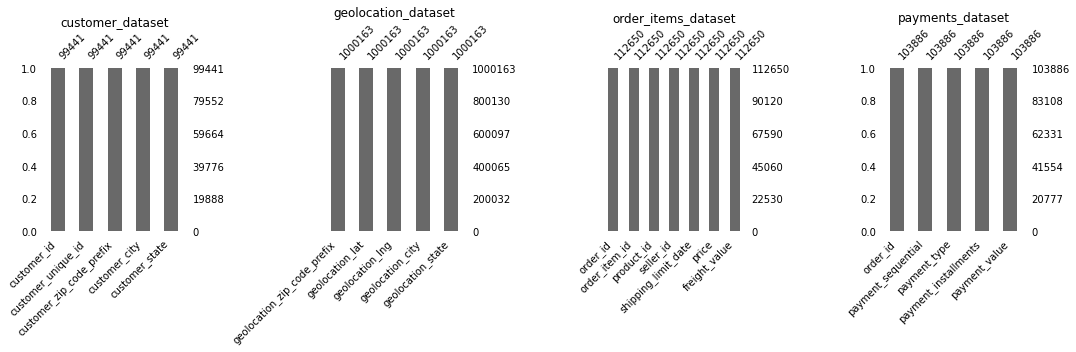

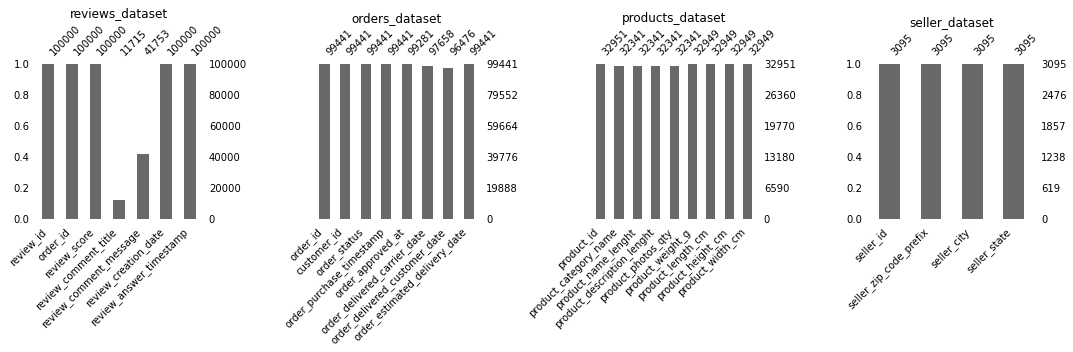

In [25]:
# Using only one figure and the fig.add_subplot method to plot data from each dataframe results in missing 
# column names for plots located in uppermost row. Using two figures we manage to get around that issue.

fig1 = plt.figure(figsize=(15, 5))
fig2 = plt.figure(figsize=(15, 5))

for i in range(4):
    ax = fig1.add_subplot(1, 4, i+1)
    ax.set_title(datasets[i][1])
    msno.bar(datasets[i][0], labels=True, fontsize=10, ax=ax)
fig1.tight_layout()

for i in range(4, 8):
    ax = fig2.add_subplot(1, 4, i+1-4)
    ax.set_title(datasets[i][1])
    msno.bar(datasets[i][0], labels=True, fontsize=10, ax=ax)
fig2.tight_layout()

Missing values are found in _reviews_dataset_, _orders_dataset_ and _products_dataset_. We choose not to do anything regarding these missing values because the lack of data can always be explained by the value of another variable: for instance, a missing _review_comment_message_ indicates that no _review_comment_message_ was sent for this specific _review_id_, or a missing _order_delivered_customer_date_ reflects the fact that the order was not (yet) delivered to the customer. On the other hand the values missing from the products dataset are more problematic: if there is no value for product_category_name, then there is no value for all other variables, except _product_id_. Therefore we might want  to get rid of all items that do not have at least a name. But it turns out not to be necessary, as merging this table with _category_translation_ will automatically remove those items from the newly created table. 

In [26]:
# merging products_data with category_translation
products_data_english = pd.merge(products_data, 
                                 category_translation, 
                                 on='product_category_name').drop(columns=['product_category_name'])
products_data_english.head()

,product_id,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english
0,1e9e8ef04dbcff4541ed26657ea517e5,40.0,287.0,1.0,225.0,16.0,10.0,14.0,perfumery
1,6a2fb4dd53d2cdb88e0432f1284a004c,39.0,346.0,2.0,400.0,27.0,5.0,20.0,perfumery
2,0d009643171aee696f4733340bc2fdd0,52.0,150.0,1.0,422.0,21.0,16.0,18.0,perfumery
3,b1eae565a61935e0011ee7682fef9dc9,49.0,460.0,2.0,267.0,17.0,13.0,17.0,perfumery
4,8da90b37f0fb171b4877c124f965b1f6,56.0,733.0,3.0,377.0,18.0,13.0,15.0,perfumery


Now let us have a look at the outliers, and more specifically at the tables order_items_dataset and payment_dataset:
* From the order_items_dataset we can calculate the total price for an order as the sum of the total prices of each item included in the order, the total price of an item being itself calculated as the sum of its price and freight values.
* From the payments_dataset we can obtain the price paid for an order through the payment_value variable. In the case several payment methods were used, the payment_sequential variable will have a value > 1. In this case calculating the payment value of an order (order_id) is done by summing all payment_value associated with the order.

We can then check whether the total_order_value match the payment_value for each order (rounded to unit precision). When it does not, we consider the order an outlier.

In [27]:
### 1. Order_items_dataset
# Let us group by order_id and calculate the sum of the price and freight values for each order
total_order_values = items_data.groupby(["order_id"]).aggregate(np.sum)[["price", "freight_value"]]

# Then the total price for an order can be obtained by summing its (total) price and its (total) freight value.
total_order_values["total_order_value"] = round(total_order_values["price"] + total_order_values["freight_value"], 0)

### 2. Payments_dataset
# Let us group by order_id and calculate the total payment_value associated with each order
order_payment_values = payments_data.groupby("order_id")[["order_id", "payment_value"]].aggregate(np.sum)

# The value is rounded to unit precision as before
order_payment_values = np.round(order_payment_values, 0)

### 3. We merge the total_order_values and order_payment_values tables using the order_id key.
order_values_item_payment = pd.merge(total_order_values, order_payment_values, on="order_id")

### 4. We can now compare the values of total_order_values and order_payment, and flag those items which values
### do not match
# Creation of match/no_match mask
order_values_item_payment["values_match"] = order_values_item_payment[["total_order_value", "payment_value"]].apply(lambda x: "match" 
                                                                    if x[0]==x[1] 
                                                                    else "no_match", axis=1)

# Items that have non-matching order and payment values
non_matching = order_values_item_payment[order_values_item_payment.values_match=="no_match"]
print(f"{round(100*non_matching.shape[0]/order_values_item_payment.shape[0], 2)}% of all items have order and payment values that do not match.")

0.26% of all items have order and payment values that do not match.


Since the order value is sometimes greater and sometimes lower than the payment value, it is not clear where this discrepancy comes from. But it concerns only 0.26% of the dataset, therefore we chose to simply get rid of these items.

In [28]:
# Get outliers indices
incoherent_orders = non_matching.index

# getting rid of these outliers from all tables.
matching_order_values_item_payment = order_values_item_payment.drop(index=incoherent_orders)
items_data = items_data[~items_data.order_id.isin(incoherent_orders)]
payments_data = payments_data[~payments_data.order_id.isin(incoherent_orders)]
reviews_data = reviews_data[~reviews_data.order_id.isin(incoherent_orders)]
orders_data = orders_data[~orders_data.order_id.isin(incoherent_orders)]

Now we can focus on getting a first look at some data that will be helpful regarding the segmentation, in particular RFM segmentation.

### RFM segmentation
We start investigating how the data at hand will allow us to perform rfm segmentation. What we look for:
- recency: date of last purchase
- frequency
- monetary value (of last purchase or average over a period of time)

The dataset _orders_data_ contains several variables dealing with time-related purchase information:
* _order_purchase_timestamp_ gives us the purchase date of any specific order (_order_id_).
* _order_id_ is related to _customer_id_ which is in turn related to _customer_unique_id_, this last variable uniquely referring to _actual_ customers.\

We will in the following: 
* create the _purchase_recency_ variable
* merge the _orders_data_ table with the _customers_data_ in order to link the _order_id_ with the _customer_id_
* create the , _frequency_ variable (#orders over a period of time for each customer)

### 1. Purchase recency

We start with the extraction of the purchase recency. Here the recency is calculated relative to the most recent timestamp found in the dataset as a first exploration.

/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


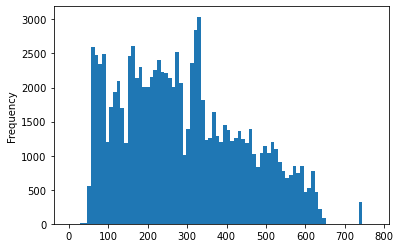

In [30]:
orders_data.loc[:, 'purchase_recency'] = orders_data.order_purchase_timestamp.max() - orders_data.order_purchase_timestamp
orders_data.loc[:, "purchase_recency"].dt.days.plot(kind='hist', bins=round(5*np.log2(orders_data.shape[0])))
plt.show()

### 2. Linking orders and customers

In [34]:
orders_customers = pd.merge(orders_data, customers_data, on="customer_id")

# we keep only interesting columns
orders_customers = orders_customers[['order_id', 'customer_id', 'order_purchase_timestamp',
                                     'purchase_recency', 'customer_unique_id']]

orders_customers.head()

,order_id,customer_id,order_purchase_timestamp,purchase_recency,customer_unique_id
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,380 days 06:33:45,7c396fd4830fd04220f754e42b4e5bff
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37,84 days 20:48:41,af07308b275d755c9edb36a90c618231
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:49,70 days 08:51:29,3a653a41f6f9fc3d2a113cf8398680e8
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,2017-11-18 19:28:06,332 days 22:02:12,7c142cf63193a1473d2e66489a9ae977
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13 21:18:39,245 days 20:11:39,72632f0f9dd73dfee390c9b22eb56dd6


The only thing left to do is replace _order_id_ with _customer_unique_id_, while keeping in mind that a customer might have purchased several items during the timespan considered. Thus we need to get the most recent purchase, and this can easily be done by grouping by customer_unique_id first, and then retain only the min() of _purchase_recency_.

In [35]:
# grouping by customer_unique_id and using min() on purchase_recency
customer_purchase_recency = orders_customers.groupby("customer_unique_id")["purchase_recency"].min().dt.days
customer_purchase_recency.head()

customer_unique_id
0000366f3b9a7992bf8c76cfdf3221e2    160
0000b849f77a49e4a4ce2b2a4ca5be3f    163
0000f46a3911fa3c0805444483337064    585
0000f6ccb0745a6a4b88665a16c9f078    369
0004aac84e0df4da2b147fca70cf8255    336
Name: purchase_recency, dtype: int64

### 3. Purchase frequency

To obtain the frequency, we group by _customer_unique_id_ and get the number of items purchased by each customer (over the period considered, in this first exploration this time period correponds to the timespan between the most recent and the oldest purchases found in the database. 

<AxesSubplot:ylabel='Frequency'>

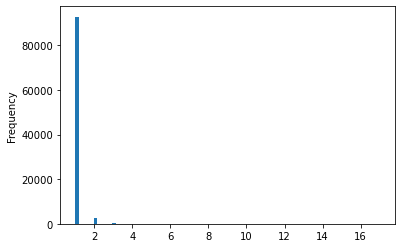

In [36]:
frequency = orders_customers.groupby("customer_unique_id")["order_id"].size()
frequency.plot(kind='hist', bins=round(5*np.log2(orders_customers.shape[0])))

### 4. Monetary value

We have the number of purchases, the timespan: we can easily get the (annual, quarterly, monthly, weekly) purchase frequencies. Let us now get the monetary value by merging the _orders_value_item_payment_ dataframe on the _order_id_ key.

In [39]:
# the columns we'll need
cols_to_keep = ["customer_unique_id",
                "purchase_recency",
                "total_order_value"]

# merge total_order_values (order_id) and orders_customers (order_id, customer_id, customer_unique_id)
df = pd.merge(orders_customers, total_order_values.reset_index(), on="order_id")[cols_to_keep]

# In the case several orders were purchased at the **exact** same time (happened at least once), we sum
# over all orders
monetary_value = df.groupby(["customer_unique_id","purchase_recency"]).aggregate(np.sum)

# Finally, grouping only by customer_unique_id, we are able to select the most recent purchase simply by 
# selecting the first element within each group because the previous groupby operation sorted 
# the customer_unique_id and purchase_recency keys in ascending order
monetary_value_last = monetary_value.reset_index().groupby("customer_unique_id").first()

# In order to get the average value of all purchase made by a customer
monetary_value_avg = monetary_value.reset_index().groupby("customer_unique_id").mean()

Let us now concatenate all three new columns (recency, frequency, monetary value).\
The tables _items_data_, _payments_data_, _orders_data_ contain different numbers of unique _order_id_ values. For the sake of simplicity, we choose to concatenate all three dataframes keeping only the _order_id_ found in all tables simultaneaously. 

In [40]:
rfm = pd.concat([customer_purchase_recency,
                frequency,
                monetary_value_avg], axis=1, join='inner').rename(columns={"order_id": "frequency"})
rfm.head()

,purchase_recency,frequency,total_order_value
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,160,1,142.0
0000b849f77a49e4a4ce2b2a4ca5be3f,163,1,27.0
0000f46a3911fa3c0805444483337064,585,1,86.0
0000f6ccb0745a6a4b88665a16c9f078,369,1,44.0
0004aac84e0df4da2b147fca70cf8255,336,1,197.0


# RFM Segmentation

Let us have an overall look at the data

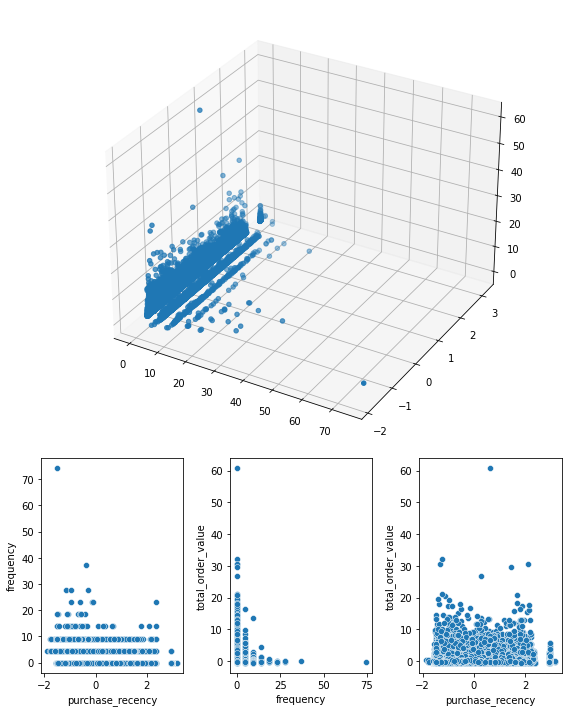

In [43]:
# scale the data, creates a dataframe for convenience
df_norm = preprocessing.scale(rfm)
df_norm = pd.DataFrame(data=df_norm, columns=["purchase_recency", "frequency", "total_order_value"])

fig = plt.figure(figsize=(8, 10))
x = df_norm.purchase_recency
y = df_norm.frequency
z = df_norm.total_order_value

ax = fig.add_subplot(3, 3, (1, 6), projection="3d")
ax.scatter(y, x, z)
ax.set_xlabel("frequency")
ax.set_ylabel("purchase_recency")
ax.set_zlabel("total_order_values")

ax = fig.add_subplot(337)
sns.scatterplot(data=df_norm, y="frequency", x="purchase_recency", ax=ax)

ax = fig.add_subplot(338)
sns.scatterplot(data=df_norm, x="frequency", y="total_order_value", ax=ax)

ax = fig.add_subplot(339)
sns.scatterplot(data=df_norm, x="purchase_recency", y="total_order_value", ax=ax)

plt.tight_layout()

Let's remove a few outliers that were not caught in previous processings.\
We want that:
- frequency < 50
- total_order_value < 40
(in scaled units)

In [45]:
# remove outliers
df_norm = df_norm[(df_norm.frequency<50)&(df_norm.total_order_value<25)]

Let us now proceed with the segmentation. On this dataset, what segmentation (n_clusters) is best?

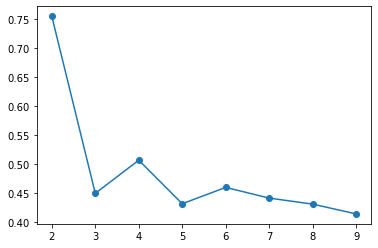

In [46]:
X = df_norm.values
silhouettes = []
cluster_list = []

for num_clusters in range(2, 10):
    cls = cluster.KMeans(n_clusters=num_clusters, n_init=10).fit(X)
    cluster_list.append(cluster)
    silh = metrics.silhouette_score(X, cls.labels_, sample_size=1000)
    silhouettes.append(silh)

plt.plot(range(2, 10), silhouettes, marker='o')

It seems that the best silhouette score is obtained for two clusters. However, for "business" reasons, we might prefer more clusters: let us try with 4.

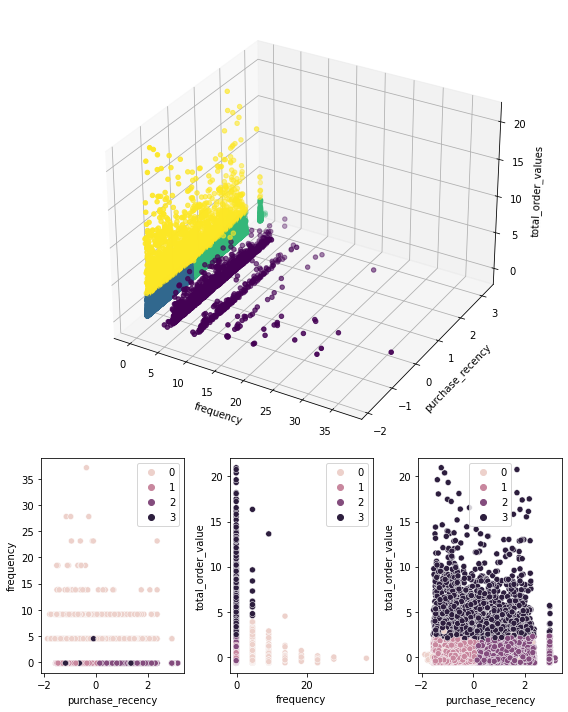

In [47]:
clusters = cluster.KMeans(n_clusters=4, n_init=10).fit(X)

# scale the data, creates a dataframe for convenience
fig = plt.figure(figsize=(8, 10))
x = df_norm.purchase_recency
y = df_norm.frequency
z = df_norm.total_order_value

ax = fig.add_subplot(3, 3, (1, 6), projection="3d")
ax.scatter(y, x, z, c=clusters.labels_)
ax.set_xlabel("frequency")
ax.set_ylabel("purchase_recency")
ax.set_zlabel("total_order_values")

ax = fig.add_subplot(337)
sns.scatterplot(data=df_norm, y="frequency", x="purchase_recency", hue=clusters.labels_, ax=ax)

ax = fig.add_subplot(338)
sns.scatterplot(data=df_norm, x="frequency", y="total_order_value", hue=clusters.labels_, ax=ax)

ax = fig.add_subplot(339)
sns.scatterplot(data=df_norm, x="purchase_recency", y="total_order_value", hue=clusters.labels_, ax=ax)

plt.tight_layout()